In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Load dataset
df = pd.read_csv('preprocessed_data.csv', low_memory=False)

In [3]:
df.describe()

Unnamed: 0            Id   LowestSalary  HighestSalary  \
count  304312.000000  3.043120e+05  304312.000000  304312.000000   
mean   152155.500000  3.779338e+07      66.563691     116.192651   
std     87847.451896  2.988405e+05      50.994459     180.602380   
min         0.000000  3.167109e+07       0.000000      30.000000   
25%     76077.750000  3.750835e+07      30.000000      40.000000   
50%    152155.500000  3.770907e+07      60.000000      70.000000   
75%    228233.250000  3.801669e+07     100.000000     120.000000   
max    304311.000000  3.856613e+07     200.000000     999.000000   

       AverageSalary           Year          Month            Day  \
count  304312.000000  304312.000000  304312.000000  304312.000000   
mean       91.378171    2018.302587       7.864652      13.961927   
std       110.171184       0.459379       4.423799       8.150803   
min        15.000000    2018.000000       1.000000       1.000000   
25%        35.000000    2018.000000       2.000000       8.000000   
50%        65.000000    2018.000000      10.000000      13.000000   
75%       110.000000    2019.000000      11.000000      19.000000   
max       599.500000    2019.000000      12.000000      31.000000   

           DayOfWeek  
count  304312.000000  
mean        2.266828  
std         1.601637  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         6.000000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304312 entries, 0 to 304311
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         304312 non-null  int64  
 1   Id                 304312 non-null  int64  
 2   Title              304312 non-null  object 
 3   Company            292858 non-null  object 
 4   Date               304312 non-null  object 
 5   Location           183064 non-null  object 
 6   Area               113751 non-null  object 
 7   Classification     183064 non-null  object 
 8   SubClassification  183064 non-null  object 
 9   Requirement        304307 non-null  object 
 10  FullDescription    291001 non-null  object 
 11  LowestSalary       304312 non-null  int64  
 12  HighestSalary      304312 non-null  int64  
 13  JobType            291076 non-null  object 
 14  AverageSalary      304312 non-null  float64
 15  Year               304312 non-null  int64  
 16  Mo

In [5]:
def Regressor(X, y, categorical_features, n_estimators):
    # Preprocessing pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combining preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define the model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1))
    ])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    mean_salary = y_test.mean()
    relative_mae = mae / mean_salary

    print(f'\nTrained on feature set: {categorical_features}')

    print(f'\nMean Salary: {mean_salary}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Relative MAE: {relative_mae * 100:.2f}%')

    return model, X_test, y_test, y_pred

In [6]:
unique_jobType = df['JobType'].unique()
print(unique_jobType)

[nan 'Full Time' 'Contract/Temp' 'Part Time' 'Casual/Vacation']


In [7]:
#filtered_df = df[(df['JobType'] == 'Full Time') | (df['JobType'] == 'Contract/Temp')]
filtered_df = df[(df['JobType'] == 'Full Time')]

### Initial Findings from model
- Lower mean absolute error when only keeping 'Full Time' JobType, although, may be less accurate when trying to predict other JobTypes.

- We also tested a Random Forest Regressor, which took ~40 times longer to fit the model than the LGBMRegressor, with 10% of the data, and 10% of the n_estimators. It did not provide noticable accuracy improvements.

**We also tested a Random Forest Regressor, which took ~40 times longer to fit the model than the LGBMRegressor, with 10% of the data, and 10% of the n_estimators. It did not provide noticable accuracy improvements.**

In [8]:
categorical_features = ['Title', 'Company', 'Date', 'Location', 'Area', 'Classification', 'SubClassification', 'JobType', 'Year', 'Month', 'Day', 'DayOfWeek']
# Splitting features and target
X = df[categorical_features]
y = df['AverageSalary']
n_estimators = 100

model_allfeat, X_test_allfeat, y_test_allfeat, y_pred_allfeat = Regressor(X, y, categorical_features, n_estimators)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.314478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6696
[LightGBM] [Info] Number of data points in the train set: 243449, number of used features: 3348
[LightGBM] [Info] Start training from score 91.478047

Trained on feature set: ['Title', 'Company', 'Date', 'Location', 'Area', 'Classification', 'SubClassification', 'JobType', 'Year', 'Month', 'Day', 'DayOfWeek']

Mean Salary: 90.97867341406109
Mean Absolute Error: 42.17853681822634
Relative MAE: 46.36%


## Interactive Visualisations

In [9]:
# Interactive plot of actual vs. predicted salaries
fig = px.scatter(x=y_test_allfeat, y=y_pred_allfeat, labels={'x': 'Actual Salary', 'y': 'Predicted Salary'},
                 title='Actual vs. Predicted Salaries')
fig.add_trace(go.Scatter(x=[y_test_allfeat.min(), y_test_allfeat.max()], y=[y_test_allfeat.min(), y_test_allfeat.max()],
                         mode='lines', line=dict(color='red', dash='dash'), name='Ideal Fit'))

fig.show()

In [10]:
# Interactive plot of residuals
residuals = y_test_allfeat - y_pred_allfeat
fig_residuals = px.histogram(residuals, nbins=50, labels={'value': 'Residuals'}, title='Residuals Distribution')
fig_residuals.show()

In [11]:
# Extract feature importances
importances = model_allfeat.named_steps['regressor'].feature_importances_
onehot_feature_names = model_allfeat.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': onehot_feature_names, 'Importance': importances})

# Aggregate importances by original categorical feature
aggregated_importances = []
for feature in categorical_features:
    feature_mask = importance_df['Feature'].str.startswith(feature)
    total_importance = importance_df.loc[feature_mask, 'Importance'].sum()
    aggregated_importances.append({'Feature': feature, 'Importance': total_importance})

# Add numerical features to the aggregated importances list
numerical_importances = importances[len(onehot_feature_names):]
for feature, importance in zip(X.columns[len(categorical_features):], numerical_importances):
    aggregated_importances.append({'Feature': feature, 'Importance': importance})

# Convert aggregated importances list to DataFrame
importance_df = pd.DataFrame(aggregated_importances)

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
fig_feature_importance = px.bar(importance_df, x='Importance', y='Feature', orientation='h', title='Feature Importance')
fig_feature_importance.show()

In [12]:
importance_df

Feature  Importance
1             Company        1013
2                Date         786
6   SubClassification         314
5      Classification         266
0               Title         198
10                Day         137
7             JobType         124
9               Month          89
3            Location          50
11          DayOfWeek          34
4                Area          23
8                Year           0

### Based on the feature importance, we will train a new model

In [13]:
threshold = 100

selected_features = list(importance_df[importance_df['Importance'] > threshold]['Feature'])
# Splitting features and target
X_selected = X[selected_features]
y = df['AverageSalary']
n_estimators = 100

model_subfeat, X_test_subfeat, y_test_subfeat, y_pred_subfeat = Regressor(X_selected, y, selected_features, n_estimators)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6494
[LightGBM] [Info] Number of data points in the train set: 243449, number of used features: 3247
[LightGBM] [Info] Start training from score 91.478047

Trained on feature set: ['Company', 'Date', 'SubClassification', 'Classification', 'Title', 'Day', 'JobType']

Mean Salary: 90.97867341406109
Mean Absolute Error: 42.488301883699734
Relative MAE: 46.70%


**By selecting only those features above the threshold of 100, we receive practically the same accuracy, with a slightly quicker training time.**

## We will try some methods for improving accuracy

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
def TuneModel(X, y, model, selected_features, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Use the best estimator for prediction
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)

    # Evaluate performance
    mean_salary = y_test.mean()
    mae_best = mean_absolute_error(y_test, y_pred_best)
    relative_mae = mae_best / mean_salary

    print(f'\nTrained on feature set: {selected_features}')

    print(f'\nMean Salary: {mean_salary}')
    print(f'Mean Absolute Error (Best Model): {mae_best}')
    print(f'Relative MAE: {relative_mae * 100:.2f}%')

    return grid_search, X_test, y_test, y_pred_best

In [16]:
# Splitting features and target
X = df[categorical_features]
y = df['AverageSalary']

# Define hyperparameter grid for LightGBM
param_grid = {
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__num_leaves': [31, 50, 100],
    'regressor__max_depth': [3, 5, -1]
}

gs_tunedmodel, X_test_gs_tunedmodel, y_test_gs_tunedmodel, y_pred_best_gs_tunedmodel = TuneModel(X, y, model_allfeat, categorical_features, param_grid)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.412025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6696
[LightGBM] [Info] Number of data points in the train set: 243449, number of used features: 3348
[LightGBM] [Info] Start training from score 91.478047
Best Hyperparameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': -1, 'regressor__num_leaves': 100}

Trained on feature set: ['Title', 'Company', 'Date', 'Location', 'Area', 'Classification', 'SubClassification', 'JobType', 'Year', 'Month', 'Day', 'DayOfWeek']

Mean Salary: 90.97867341406109
Mean Absolute Error (Best Model): 39.20304991216834
Relative MAE: 43.09%


**This tuning took nearly 3 minutes, but we have identified the following hyperparameters to be the best for this model:**
- regressor__learning_rate: 0.2
- regressor__max_depth: -1
- regressor__num_leaves: 100

**Lets visualise the results**

In [17]:
# Interactive plot of actual vs. predicted salaries
fig = px.scatter(x=y_test_gs_tunedmodel, y=y_pred_best_gs_tunedmodel, labels={'x': 'Actual Salary', 'y': 'Predicted Salary'},
                 title='Actual vs. Predicted Salaries')
fig.add_trace(go.Scatter(x=[y_test_gs_tunedmodel.min(), y_test_gs_tunedmodel.max()], y=[y_test_gs_tunedmodel.min(), y_test_gs_tunedmodel.max()],
                         mode='lines', line=dict(color='red', dash='dash'), name='Ideal Fit'))

fig.show()

In [18]:
# Interactive plot of residuals
residuals = y_test_gs_tunedmodel - y_pred_best_gs_tunedmodel
fig_residuals = px.histogram(residuals, nbins=50, labels={'value': 'Residuals'}, title='Residuals Distribution')
fig_residuals.show()

In [23]:
# Extract grid search results
results = pd.DataFrame(gs_tunedmodel.cv_results_)

# Pivot the results to create a grid for the heatmap
pivot_table = results.pivot_table(index='param_regressor__num_leaves', 
                                  columns=['param_regressor__max_depth', 'param_regressor__learning_rate'], 
                                  values='mean_test_score')

# Create a series of subplots for each learning rate
fig = go.Figure()

for lr in param_grid['regressor__learning_rate']:
    sub_pivot = pivot_table.xs(lr, level='param_regressor__learning_rate', axis=1)
    fig.add_trace(go.Surface(z=sub_pivot.values,
                              x=sub_pivot.columns.get_level_values(0),
                              y=sub_pivot.index,
                              name=f'Learning Rate: {lr}'))

# Customize the layout
fig.update_layout(title='Grid Search Results (MAE)',
                  scene=dict(xaxis_title='Max Depth',
                             yaxis_title='Num Leaves',
                             zaxis_title='MAE'),
                  height=800, width=1200)

# Show the interactive plot
fig.show()

### Scatter Plot Matrix (SPLOM)

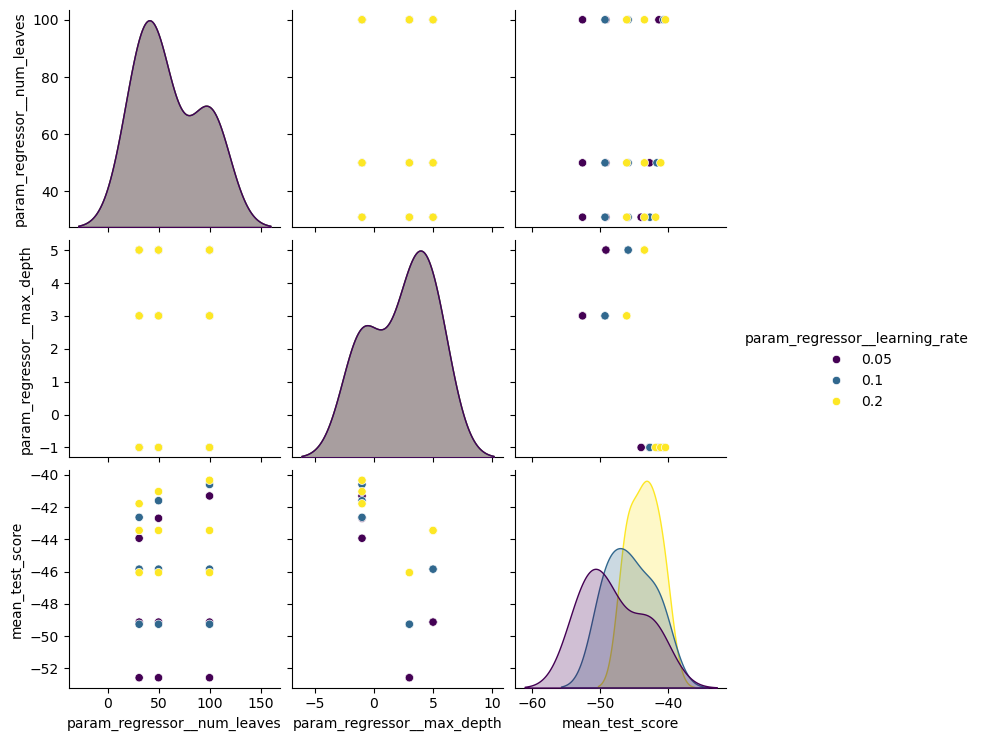

In [32]:
# Select relevant columns for SPLOM
relevant_cols = ['param_regressor__learning_rate', 'param_regressor__num_leaves', 'param_regressor__max_depth', 'mean_test_score']
sploam_data = results[relevant_cols]

# Plot SPLOM
sns.pairplot(sploam_data, hue='param_regressor__learning_rate', palette='viridis')
plt.show()

In [33]:
# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=results['param_regressor__num_leaves'],
    y=results['param_regressor__max_depth'],
    z=results['mean_test_score'],
    mode='markers',
    marker=dict(
        size=8,
        color=results['param_regressor__learning_rate'],  # Color by learning rate
        colorscale='Viridis',  # Set color scale
        opacity=0.8
    )
)])

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='Num Leaves',
        yaxis_title='Max Depth',
        zaxis_title='MAE'
    ),
    title='3D Scatter Plot of Hyperparameters and MAE'
)

# Show plot
fig.show()